In [25]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math
import matplotlib.pyplot as plt


#%matplotlib


import seaborn as sns


import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim
import pickle 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [26]:
sim = torch.load("REAL_SIM.pt")

In [27]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
activity = activity[:,:300]

Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

# Initializing the parameters 

In [28]:
dtData=sim['params']['dtData'] # time step of training data
# dtData=None
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
# tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
tauRNN=50 # decay constant of RNN 

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
resetPoints=None
plotStatus=True
regions=None


In [29]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [30]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300
dtRNN = dtData / float(dtFactor) # 0.01/5=0.002

In [31]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps

# External Input to RNN

In [32]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = ampInWN * inputWN # external input h(t)


# Set up target training data

In [33]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max
print (Adata.shape)

(300, 300)


# Model Definition

In [34]:
import sys 

class CTRNN(nn.Module):
    """Continuous-time RNN."""
    def __init__(self,
                 g,
                 tauRNN,
                 dtRNN,
                 input_units,
                 output_units,
                 dt=None,
                 interregion_sparsity=0.1, #Lower = more sparse, 1 to disable
                 intraregion_sparsity=0.1, # Lower = sparser, 1 to disble
                 **kwargs):
      
        super(CTRNN,self).__init__()

        self.tauRNN = tauRNN
        self.dtRNN=dtRNN
        self.g=g
        self.input_units=input_units
        self.output_units=output_units
        
        
#        print(self.J)
        mask = torch.ones(300,300)
        mask[:100, 100:300] = torch.rand_like(mask[:100, 100:300]) <= interregion_sparsity
        mask[100:200, 0:100] = torch.rand_like(mask[100:200, 0:100]) <= interregion_sparsity
        mask[100:200, 200:] = torch.rand_like(mask[100:200, 200:]) <= interregion_sparsity
        mask[200:,0:200] = torch.rand_like(mask[200:,0:200]) <= interregion_sparsity
        
        mask[:100, :100] = torch.rand_like(mask[:100, :100]) <= intraregion_sparsity
        mask[100:200, 100:200] = torch.rand_like(mask[:100, :100]) <= intraregion_sparsity
        mask[200:, 200:] = torch.rand_like(mask[:100, :100]) <= intraregion_sparsity
        
        self.mask = mask
        self.J = nn.Parameter((self.g * torch.Tensor(npr.randn(input_units, output_units) / math.sqrt(output_units)))  * self.mask )

        #print(torch.numel(mask[0:100, 100:]))
      
    def forward(self, hidden, noise=None):
        if(noise is not None):
           noise = torch.zeros_like(noise)
        
        """Propogate input through the network."""
        
        # When calculating fixed points: We want to find _hidden_ vectors such that -hidden + JR equals the 0 vector.
        activation = torch.tanh(torch.Tensor(hidden))
        JR = torch.matmul(self.J, activation).reshape((self.input_units,1))
        

        new_hidden = hidden + self.dtRNN*(-hidden + JR)/self.tauRNN
        return activation, new_hidden



In [35]:

g = 1.5
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units)

rnn_model.to(device)
rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))
rnn_model.load_state_dict(torch.load("intraregion_sparse_weights.pt"))
weights_initial = rnn_model.J.detach().cpu().numpy().copy()


In [12]:
def run_trajectory(model, starting_point, iterations=100, form='nparray'):
    trajectory = []
    trajectory.append(starting_point)
    for iteration in range(iterations):
        activation, new_hidden = model(starting_point)
        trajectory.append(new_hidden)
        starting_point = new_hidden
    
    if(form == 'nparray'):
       return torch.cat(trajectory, dim=1).detach().numpy().T
    else:
       return torch.cat(trajectory, dim=1).detach().T

In [13]:
fixed_points = torch.load("REAL_FIXED_POINTS.pt")
random_point = (torch.rand_like(fixed_points[0])-0.5) * 10
random_points = [(torch.rand_like(fixed_points[0])-0.5) * 400 for _ in range(10)]


In [14]:
trajectories = [run_trajectory(rnn_model, fixed_points[i], iterations=200000,  form='torch') for i in range(len(fixed_points)) ]

KeyboardInterrupt: 

In [ ]:
random_trajectories = [run_trajectory(rnn_model, random_points[i], iterations=200000,  form='torch') for i in range(len(random_points)) ]

In [15]:
random_trajectories = torch.load('10r_200k.pt')

In [16]:
trajectories = torch.load("10_200k.pt")
#torch.save(random_trajectories[:4], '10r_200k.pt')

In [17]:
all = torch.cat(trajectories, dim=0)

In [18]:
all.shape

torch.Size([2000010, 300])

In [19]:
import numpy as np
from sklearn.decomposition import PCA
import pickle

pca = PCA(n_components=3)
pca2 = PCA(n_components=2)

In [20]:
pca.fit(all)

PCA(n_components=3)

In [21]:
# fitted = [pca.transform(trajectory) for trajectory in trajectories]
random_fitted = [pca.transform(trajectory) for trajectory in random_trajectories]

In [22]:
fitted_1 = pca.transform(random_trajectories[0])
#fitted_2 = pca.transform(trajectories[1])

In [23]:
colormaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

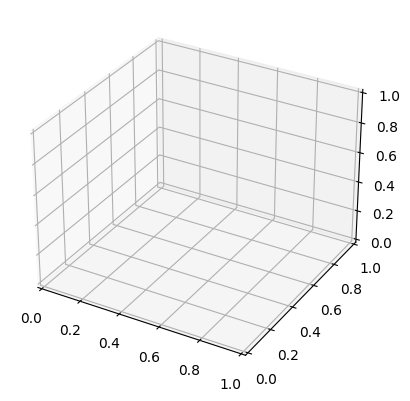

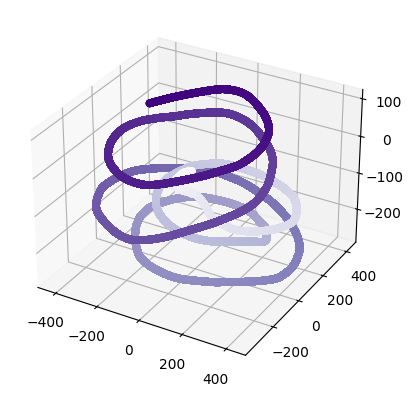

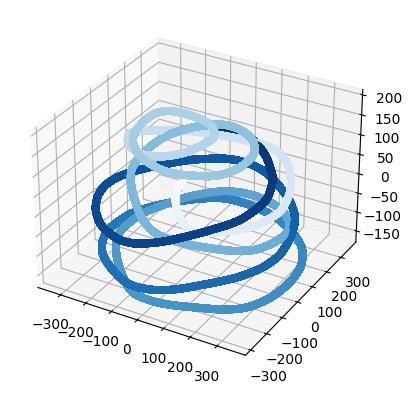

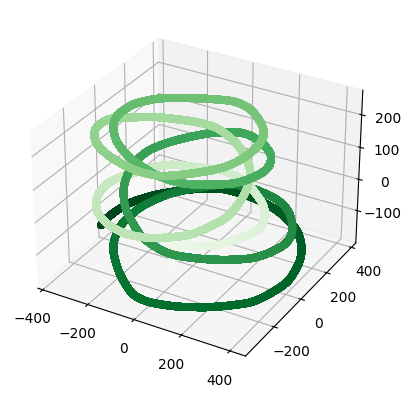

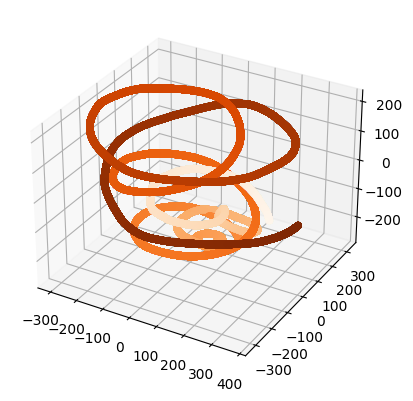

In [24]:
xs = [fitted_i[:,0] for fitted_i in random_fitted]
ys = [fitted_i[:,1] for fitted_i in random_fitted]
zs = [fitted_i[:,2] for fitted_i in random_fitted]

x_1 = fitted_1[:,0]

fig = plt.figure()
ax = plt.axes(projection='3d')

for index in range(len(xs)):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(xs[index], ys[index], zs[index], c=np.arange(0,x_1.shape[0]), cmap=colormaps[index], label='trajectory near fixed point', linewidth=1.0)
    plt.show()

#ax.legend()
plt.show()


In [ ]:
fixed_points = torch.cat(fixed_points,)

In [ ]:
list(fixed_points.reshape(10,300)[:,0])

In [ ]:
fig, ax = plt.subplots()

x = pca2.fit_transform(fixed_points.reshape(10,300))[:,0]
y = pca2.fit_transform(fixed_points.reshape(10,300))[:,1]
ax.scatter(x, y)

for i in range(len(x)):
    ax.annotate(i, (x[i], y[i]))


In [ ]:
perturbed_pt_1 = fixed_points[0] + torch.rand_like(fixed_points[0])*0.01

In [76]:
pt_20_20_20 = torch.Tensor(pca.inverse_transform((20,20,20))).unsqueeze(1)
pt_100_100_100 = torch.Tensor(pca.inverse_transform((100,100,100))).unsqueeze(1)

In [86]:
random_trajectory = run_trajectory(rnn_model, random_point, iterations=10000)
pca.fit(random_trajectory)

PCA(n_components=3)

In [88]:
with open("PCA.pkl", 'rb') as f:
    pca = pickle.load(f)

In [92]:
def get_random_points(num_points=100, low=-100, high=100):
    return (torch.rand((num_points, 300)) - 0.5) * 200



In [103]:
def get_all_trajectories(model, candidate_points, iterations=30000):
    all_trajectories = []
    for starting_point in candidate_points:
        
        trajectory = run_trajectory(model=model, starting_point=starting_point.unsqueeze(1), iterations=iterations)
        all_trajectories.append(trajectory)
    
    return all_trajectories

In [185]:
points = get_random_points(num_points=5)
all_trajectories = get_all_trajectories(rnn_model, points, iterations=10000)


In [186]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for i,trajectory in enumerate(all_trajectories):
    # fig = plt.figure()
    # ax = plt.axes(projection='3d')
    
    print(pca.transform(trajectory).shape)
    transformed = pca.transform(trajectory)
    ax.scatter3D(transformed[:,0], transformed[:,1], transformed[:,2], c=np.arange(0,transformed[:,0].shape[0]), cmap='Reds', label='trajectory near fixed point');
    print("test")


# ax.legend()
plt.show()


(10001, 3)
test
(10001, 3)
test
(10001, 3)
test
(10001, 3)
test
(10001, 3)
test


In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')


#ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Greens');
ax.scatter3D(x_1, y_1, z_1, c=np.arange(0,x_1.shape[0]), cmap='Reds', label='trajectory near fixed point');
#ax.scatter3D(x_2, y_2, z_2, c=np.arange(0,x_1.shape[0]), cmap='Blues', label='trajectory at random point');
#ax.scatter3D(x_3, y_3, z_3, c=np.arange(0,x_1.shape[0]), cmap='Greens', label='trajectory fixed point');
#ax.scatter3D(x_4, y_4, z_4, c=np.arange(0,x_1.shape[0]), cmap='plasma', label='trajectory fixed point');
ax.scatter3D(x_5, y_5, z_5, c=np.arange(0,x_5.shape[0]), cmap='Reds', label='trajectory fixed 5 point');


ax.legend()
plt.show


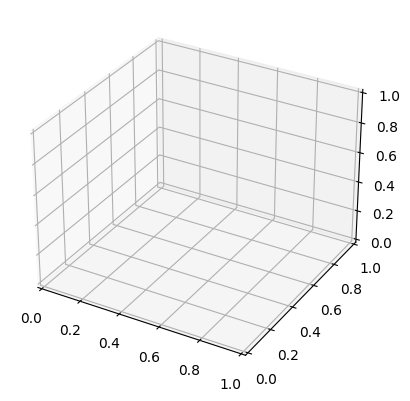

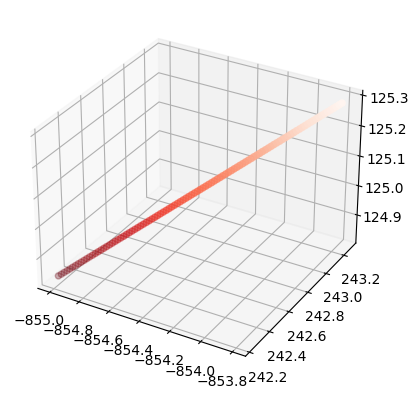

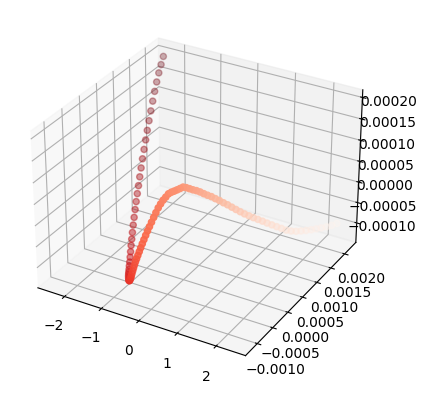

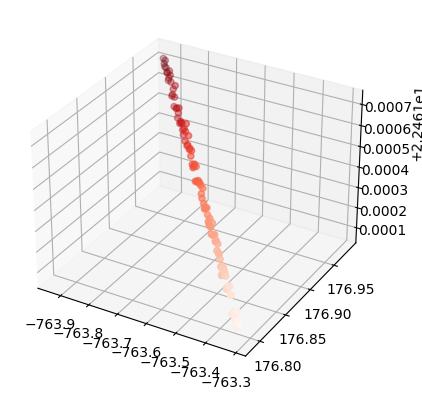

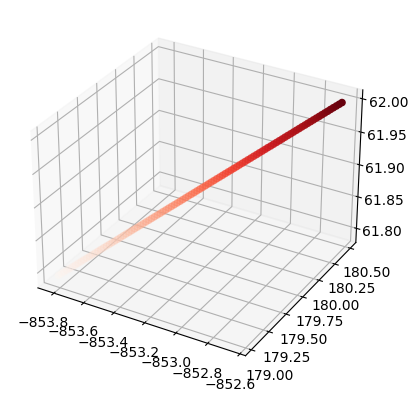

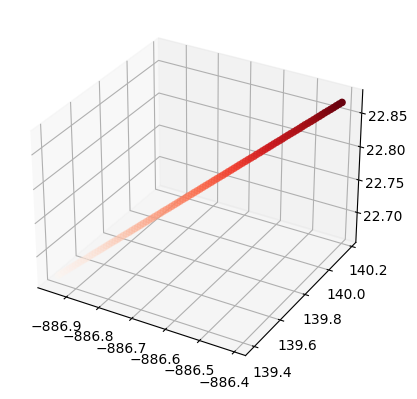

In [154]:
def plot_fn(plt,ax,trajectory,n_components=3):

    if n_components== 3:
        x = trajectory[:,0]
        y = trajectory[:,1]
        z = trajectory[:,2]
        ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Reds');

    if n_components== 2:
        x = trajectory[:,0]
        y = trajectory[:,1]
        ax.scatter(x, y, c=np.arange(0,x.shape[0]), cmap='Reds');


def plot_trajectories(trajectories, n_components=3):
    fitted = []
    pca = PCA(n_components=n_components)

    pca.fit(trajectories[1])
    #first_fitted = pca.transform(trajectories[0])
    # fitted = pca.fit(trajectories)
    # first_fitted= pca.transform(trajectories[0])
    #fitted.append(first_fitted)

    fig = plt.figure()
    if n_components==3:
        ax = plt.axes(projection='3d')
    else :
        ax= plt.axes()

    #plot_fn(plt,ax,first_fitted,n_components)

    for i, trajectory_data in enumerate(trajectories):
        
        
        fitted_trajectory = pca.transform(trajectory_data)
        # fitted.append(fitted_trajectory)

        fig = plt.figure()
        if n_components==3:
            ax = plt.axes(projection='3d')
        else :
            ax= plt.axes()

        plot_fn(plt,ax,fitted_trajectory,n_components)

    return fig

f = plot_trajectories(all_trajectories, n_components=3 )



<function matplotlib.pyplot.show(close=None, block=None)>

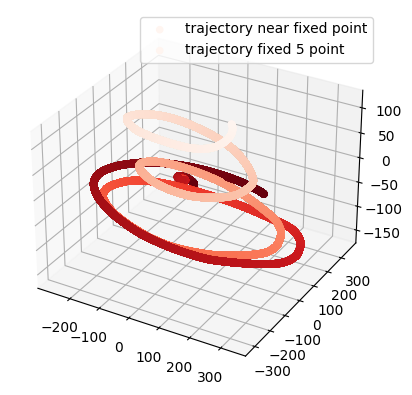

In [155]:
fig = plt.figure()


ax = plt.axes(projection='3d')

#ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Greens');
ax.scatter3D(x_1, y_1, z_1, c=np.arange(0,x_1.shape[0]), cmap='Reds', label='trajectory near fixed point');
#ax.scatter3D(x_2, y_2, z_2, c=np.arange(0,x_1.shape[0]), cmap='Blues', label='trajectory at random point');
#ax.scatter3D(x_3, y_3, z_3, c=np.arange(0,x_1.shape[0]), cmap='Greens', label='trajectory fixed point');
#ax.scatter3D(x_4, y_4, z_4, c=np.arange(0,x_1.shape[0]), cmap='plasma', label='trajectory fixed point');
ax.scatter3D(x_5, y_5, z_5, c=np.arange(0,x_5.shape[0]), cmap='Reds', label='trajectory fixed 5 point');


ax.legend()
plt.show()

In [166]:
x_1.shape

(10001,)

In [107]:
all_trajectories[0].shape

(101, 300)

In [97]:
points.shape

torch.Size([100, 300])

In [75]:
totorch.save(trajectory_5, "10ktrajectory.pt")

In [83]:
# Run a trajectory starting at the 9th fixed point for 100 iterations
random_point = torch.rand_like(fixed_points[0])
'''trajectory_1 = run_trajectory(rnn_model, fixed_points[0], iterations=10000)
trajectory_2 = run_trajectory(rnn_model, random_point, iterations=10000)
trajectory_3 = run_trajectory(rnn_model, perturbed_pt_1, iterations=10000)
trajectory_4 = run_trajectory(rnn_model, pt_20_20_20, iterations=10000)
'''
trajectory_5 = run_trajectory(rnn_model, pt_100_100_100, iterations=100000)


fitted_1 = pca.transform(trajectory_1)
fitted_2 = pca.transform(trajectory_2)
fitted_3 = pca.transform(trajectory_3)
fitted_4 = pca.transform(trajectory_4)
fitted_5 = pca.transform(trajectory_5)

fitted2_1 = pca2.fit_transform(trajectory_1)
fitted2_2 = pca2.transform(trajectory_2)
fitted2_3 = pca2.transform(trajectory_3)
fitted2_4 = pca2.transform(trajectory_4)

x_1 = fitted_1[:,0]
y_1 = fitted_1[:,1]
z_1 = fitted_1[:,2]

x_2 = fitted_2[:,0]
y_2 = fitted_2[:,1]
z_2 = fitted_2[:,2]

x_3 = fitted_3[:,0]
y_3 = fitted_3[:,1]
z_3 = fitted_3[:,2]

x_4 = fitted_4[:,0]
y_4 = fitted_4[:,1]
z_4 = fitted_4[:,2]

x_5 = fitted_5[:,0]
y_5 = fitted_5[:,1]
z_5 = fitted_5[:,2]




<function matplotlib.pyplot.show(close=None, block=None)>

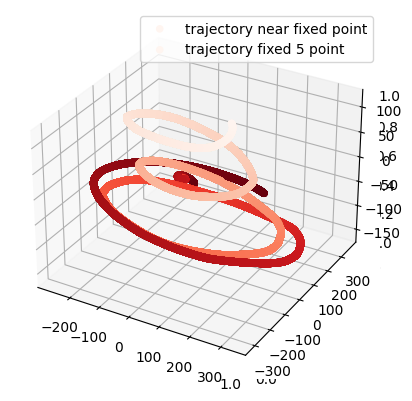

In [84]:

fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

#ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Greens');
ax.scatter3D(x_1, y_1, z_1, c=np.arange(0,x_1.shape[0]), cmap='Reds', label='trajectory near fixed point');
#ax.scatter3D(x_2, y_2, z_2, c=np.arange(0,x_1.shape[0]), cmap='Blues', label='trajectory at random point');
#ax.scatter3D(x_3, y_3, z_3, c=np.arange(0,x_1.shape[0]), cmap='Greens', label='trajectory fixed point');
#ax.scatter3D(x_4, y_4, z_4, c=np.arange(0,x_1.shape[0]), cmap='plasma', label='trajectory fixed point');
ax.scatter3D(x_5, y_5, z_5, c=np.arange(0,x_5.shape[0]), cmap='Reds', label='trajectory fixed 5 point');


ax.legend()
plt.show


In [ ]:

plt.plot(fitted2_1[:,0],fitted2_1[:,1], label='starting very close to fixed point') 
plt.plot(fitted2_2[:,0],fitted2_2[:,1], label='starting at a random point') 
plt.plot(fitted2_3[:,0],fitted2_3[:,1], label='starting sort of close to a fixed point') 
plt.plot(fitted2_4[:,0],fitted2_4[:,1], label='starting at 20,20,20 in the 3d space') 

#plt.gca().set_aspect("equal") 
plt.legend()
plt.show()


NameError: name 'g_list' is not defined

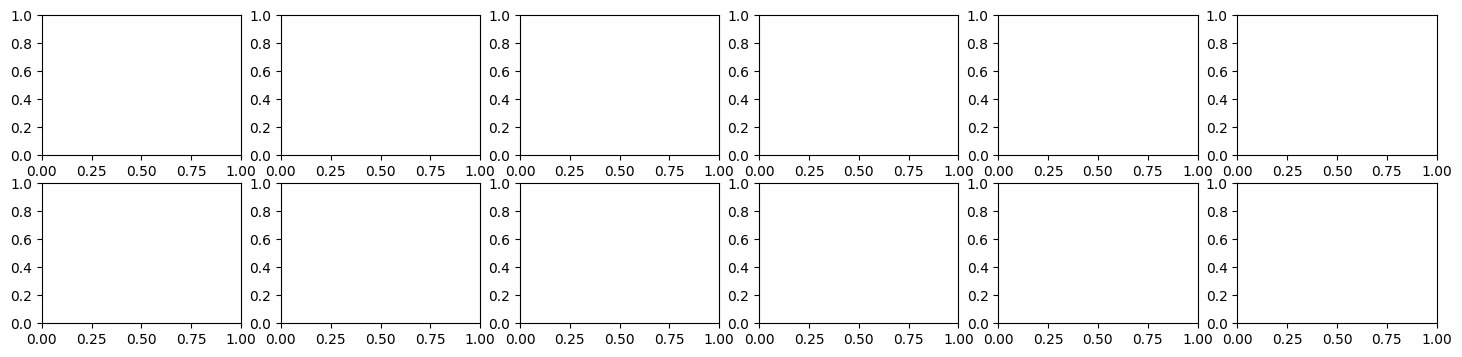

In [2]:
from glob import glob
import matplotlib.pyplot as plt
fig, ax =plt.subplots(2,6, figsize=(18,4))


for i,g_val in enumerate(g_list):

    meta_file = glob(f'/content/drive/MyDrive/Colab Notebooks/CURBD/g_expt/{g_val}/meta*')[0]
    meta_data = torch.load(meta_file)
    loss_list = [i.item() for i in meta_data['loss_list']]
    # plt.plot(loss_list, label=f'g val = {g_val}');

    intial_w = meta_data['weights_initial']
    final_w = meta_data['trained_weights']
    s=sns.heatmap(intial_w[0:10,0:10], ax=ax[0][i])
    t=sns.heatmap(final_w[0:10,0:10], ax=ax[1][i])
    t.set_xlabel(f'g={g_val}', fontsize=10)
    if i==0:
      s.set_ylabel(f'Initial DI Matrix', fontsize=10)
      t.set_ylabel(f'Trained DI Matrix', fontsize=10)

plt.legend()
plt.show()